# Exploratory Data Analysis for Summarised Sales Data

## Executive Summary

**What is this notebook for?**

- To explore the data properties, data quality and prediction power of categorical and numerical features from the summarised sales data 
- To select relevant features and perform initial feature engineering, getting ready for experimenting with baseline ML models

**What have we learned from this notebook?** (To be updated)

1. Known data quality issues & how to fix them 
    1. Missing values
        - city: extract city from store_name
        - county: infer from the imputed values for missing city
        - category_name: impute based on category_name of the same items from other records
        - vendor_name: impute based on vendor_name of the same items from other records
2. Distribution & Outliers
    - All numerical features are heavily skewed. 
    - (Completed) Remove outliers for sale_dollars:remove records with sale_dollars exceeding $100,000.
3. Feature selection based on predictive power
4. Feature engineering
5. Important points to note

**What are the next steps after this notebook?**
1. To split original dataset into a training set and a test set
2. To conduct data preprocessing (e.g. feature scaling for numerical features, encoding for categorical features)
2. To experiment with some baseline models: XGB, Random Forest, AdaBoost, Linear Regression 

## Data Sources

summarised_sales.pkl: Summarised from all_sales.pkl

## Revision History

- 04-17-2021: Started the notebook

## Required Python Libraries

In [2]:
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# EDA

# Chi-square test and t-test for EDA
from scipy.stats import chi2_contingency
from scipy import stats

# Logistic correlation for EDA
import statsmodels.api as sm

# Data Visualisation for EDA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Set up matplotlib so it uses Jupyter's graphical backend when plotting the charts
%matplotlib inline 

# Adjust display options for pandas dataframes
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 60)
pd.set_option('float_format','{:.2f}'.format)

## File Locations

In [3]:
raw_data = Path.cwd().parent / "data" / "raw" / "all_sales.pkl"

# Summarise transactional data into training dataset for demand forecasting
summarised_data = Path.cwd().parent / "data" / "processed" / "summary_sales.pkl"

# Master file for common dimensions
item_data = Path.cwd().parent / "data" / "interim" / "item_list.pkl"

## Load the data & basic exploration

In [4]:
liquor_df = pd.read_pickle(summarised_data)
liquor_df.tail(10)

,date,item_number,vendor_name,category_name,city,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,pack,sale_dollars,bottles_sold,volume_sold_liters,item_description
6073609,2021-03-30,991350,Mara Imports,100% Agave Tequila,Coralville,JOHNSON,750,72.00,108.00,6,648.00,6,4.50,Hoyo 19 Extra Anejo
6073610,2021-03-31,28894,BACARDI USA INC,Imported Dry Gins,Washington,WASHINGTON,50,120.00,180.00,1,180.00,1,0.05,Bombay Bramble
6073611,2021-03-31,37403,PERNOD RICARD USA,Imported Flavored Vodka,Ankeny,POLK,750,9.99,14.99,6,44.97,3,2.25,Absolut Watermelon
6073612,2021-03-31,37403,PERNOD RICARD USA,Imported Flavored Vodka,Cedar Falls,BLACK HAWK,750,9.99,14.99,6,44.97,3,2.25,Absolut Watermelon
6073613,2021-03-31,37403,PERNOD RICARD USA,Imported Flavored Vodka,Des Moines,POLK,750,9.99,14.99,6,59.96,4,3.00,Absolut Watermelon
6073614,2021-03-31,38530,SAZERAC COMPANY INC,American Vodkas,Cedar Falls,BLACK HAWK,50,4.30,6.45,12,6.45,1,0.05,Wheatley Vodka Mini
6073615,2021-03-31,57279,SAZERAC COMPANY INC,Cocktails / RTD,Cedar Rapids,LINN,1750,6.50,9.75,6,58.50,6,10.50,Chi-Chi's Pink Lemonade Margarita
6073616,2021-03-31,917527,Brown Forman Corp.,Straight Bourbon Whiskies,Allerton,WAYNE,750,17.15,25.73,6,154.38,6,4.50,Coopers' Craft Reserve Kentucky Straight Bourb...
6073617,2021-03-31,946606,Modern Matriarch,Gold Rum,Council Bluffs,POTTAWATTA,750,14.00,21.00,12,504.00,24,18.00,Modern Matriarch Amber Rum
6073618,2021-03-31,946608,Modern Matriarch,Flavored Rum,Council Bluffs,POTTAWATTA,750,13.75,20.63,12,495.12,24,18.00,Modern Matriarch Salted Caramel Flavored Rum


In [5]:
liquor_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6073619 entries, 0 to 6073618
Data columns (total 14 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   item_number          object        
 2   vendor_name          object        
 3   category_name        object        
 4   city                 object        
 5   county               object        
 6   bottle_volume_ml     int64         
 7   state_bottle_cost    float64       
 8   state_bottle_retail  float64       
 9   pack                 int64         
 10  sale_dollars         float64       
 11  bottles_sold         int64         
 12  volume_sold_liters   float64       
 13  item_description     object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(6)
memory usage: 695.1+ MB


In [6]:
liquor_df.describe()

,bottle_volume_ml,state_bottle_cost,state_bottle_retail,pack,sale_dollars,bottles_sold,volume_sold_liters
count,6073619.00,6073619.00,6073619.00,6073619.00,6073619.00,6073619.00,6073619.00
mean,883.16,10.76,16.14,11.93,192.88,14.66,12.16
std,502.05,9.88,14.82,7.50,630.66,49.87,46.77
min,20.00,0.33,0.50,1.00,1.30,1.00,0.02
25%,750.00,6.00,9.00,6.00,37.48,3.00,1.75
50%,750.00,8.66,12.99,12.00,89.16,6.00,6.00
75%,1000.00,13.00,19.50,12.00,180.00,12.00,10.50
max,6000.00,1871.20,2806.80,60.00,185248.80,7920.00,11812.50


In [7]:
# Check for missing values
liquor_df.isnull().sum()

date                   0
item_number            0
vendor_name            0
category_name          0
city                   0
county                 0
bottle_volume_ml       0
state_bottle_cost      0
state_bottle_retail    0
pack                   0
sale_dollars           0
bottles_sold           0
volume_sold_liters     0
item_description       0
dtype: int64

Since majority of the univariate analysis have been covered in notebook 2-DataPrep, the below section will focus more on bivariate analysis and multi-variate analysis to discover underlying patterns about liquor sales in Iowa from 2018. 

## Bivariate Analysis

### Categorical features

In [8]:
# Check the number of unique values (i.e. cardinality) for each categorical feature
cat_feature = ['date', 'city', 'county', 'category_name', 'vendor_name', 'item_description']
liquor_df[cat_feature].nunique()

date                 847
city                 443
county               100
category_name         49
vendor_name          268
item_description    5014
dtype: int64

#### date

In [16]:
# Create new features for year, month and day of the week
liquor_df['year'] = pd.DatetimeIndex(liquor_df['date']).year
liquor_df['month'] = pd.DatetimeIndex(liquor_df['date']).month
liquor_df['day_of_week'] = pd.DatetimeIndex(liquor_df['date']).dayofweek
liquor_df.tail(50)

,date,item_number,vendor_name,category_name,city,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,pack,sale_dollars,bottles_sold,volume_sold_liters,item_description,year,month,day_of_week
6073569,2021-03-31,28893,BACARDI USA INC,Imported Dry Gins,DeWitt,CLINTON,750,13.50,20.25,6,121.50,6,4.50,Bombay Bramble,2021,3,2
6073570,2021-03-31,28893,BACARDI USA INC,Imported Dry Gins,Des Moines,POLK,750,13.50,20.25,6,243.00,12,9.00,Bombay Bramble,2021,3,2
6073571,2021-03-31,28893,BACARDI USA INC,Imported Dry Gins,Fort Madison,LEE,750,13.50,20.25,6,20.25,1,0.75,Bombay Bramble,2021,3,2
6073572,2021-03-31,28893,BACARDI USA INC,Imported Dry Gins,Sigourney,KEOKUK,750,13.50,20.25,6,20.25,1,0.75,Bombay Bramble,2021,3,2
6073573,2021-03-31,28893,BACARDI USA INC,Imported Dry Gins,Spencer,CLAY,750,13.50,20.25,6,121.50,6,4.50,Bombay Bramble,2021,3,2
6073574,2021-03-31,28893,BACARDI USA INC,Imported Dry Gins,Spirit Lake,DICKINSON,750,13.50,20.25,6,121.50,6,4.50,Bombay Bramble,2021,3,2
6073575,2021-03-31,28893,BACARDI USA INC,Imported Dry Gins,Washington,WASHINGTON,750,13.50,20.25,6,141.75,7,5.25,Bombay Bramble,2021,3,2
6073576,2021-03-31,28893,BACARDI USA INC,Imported Dry Gins,Waukee,DALLAS,750,13.50,20.25,6,40.50,2,1.50,Bombay Bramble,2021,3,2
6073577,2021-03-31,28893,BACARDI USA INC,Imported Dry Gins,West Des Moines,POLK,750,13.50,20.25,6,182.25,9,6.75,Bombay Bramble,2021,3,2
6073578,2021-03-30,4571,BACARDI USA INC,Temporary & Specialty Packages,Cedar Falls,BLACK HAWK,750,12.50,18.75,6,75.00,4,3.00,Dewar's Portuguese Smooth,2021,3,1


The date feature has very high cardinality, which would create problems for the typical one-hot encoding process and hinder the ability for the model to generalise to predict with unseen data. Therefore, I will replace the date feature with either year, month or day_of_week, depending on the predictive power of each date-related feature. 

Note: For the feature day_of_week, it is assumed the week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6.

In [31]:
# Define a function to draw boxplot between a categorical feature and a numerical label
def bivariate_boxplot(df, cat_feature, num_label):
    plt.figure(figsize = (16, 8))
    sns.set_style("whitegrid")
    sns.boxplot(x = df[cat_feature], y = df[num_label], palette = "Set3")
    return None

In [33]:
# Define a function to draw barplot between a categorical feature and a numerical label
def bivariate_barplot(df, cat_feature, num_label):
    plt.figure(figsize = (16, 8))
    sns.set_style("whitegrid")
    sns.barplot(x = df[cat_feature], y = df[num_label], palette = "Set3")
    return None

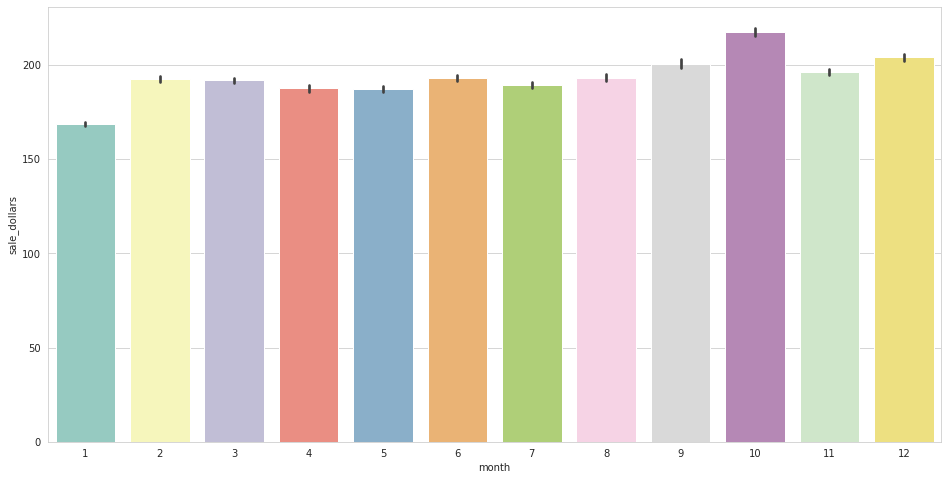

In [34]:
bivariate_barplot(liquor_df, 'month', 'sale_dollars')

#### city

#### county

#### category_name

#### vendor_name

#### item_description

### Numerical features

In [36]:
num_feature = ['pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'sale_dollars', 
               'volume_sold_liters']

In [ ]:
# Plot all distributions and scatterplot between each numerical feature pair
sns.pairplot(liquor_df, vars = num_feature)